In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder, ModelHandler
import matplotlib.pyplot as plt
from odbm.vis import *
from odbm.utils import extractParams, fmt, getStoich
import itertools


C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
excel_model = 'multi_enzyme_model_regeneration.xlsx'
model_species = pd.read_excel('Examples/'+excel_model, sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl').dropna('index','all')
model_rxns = pd.read_excel('Examples/'+excel_model, sheet_name = 'Reaction', engine = 'openpyxl').dropna('index','all')

In [3]:
expression_limit = 0.05

DNA = 1e-6 # mM
init_serine_txtl = 5 #mM
lifetime = 8 * 3600 # s
integral_serine = init_serine_txtl * lifetime /2 #mM*s

k_TXTL = expression_limit/(DNA*integral_serine) # 1/nM*s

k_TXTL_2 =  expression_limit/(DNA * lifetime * 0.025) # from Pi inhibition
# https://www.wolframalpha.com/input/?i=integral+of+1-e%5E%28-x%2F0.1%29+from+0+to+1

avg_res = 300 # average number of residues
pi_prod = 5 # Pi produced per residue
pi_fudge = 1

max_Pi = expression_limit*avg_res*pi_prod*pi_fudge # max mM of Pi

constant_params = {'k_TXTL': k_TXTL_2, 'maxC_Pi_P2': max_Pi}

In [4]:
solubilities = {    'ATP' : 98.619,
                    'Serine': 2380.952,
                    'HCO3' : 1470.588,
                    'NADH' : 150.739 
                }
sol_fudge = 1/20
solubilities = {k:v*sol_fudge for k,v in solubilities.items()}
solubilities['Serine'] = min(solubilities.values())

for k,v in solubilities.items():
    model_species.loc[model_species['Label'] == k,'StartingConc'] = v

constant_params['maxC_ATP_C0'] = solubilities['ATP']
constant_params['maxC_NADH_C0'] = solubilities['NADH']
# better to just look at OG papers

In [5]:
N = 1000*64
init_serine = {'SERINE':10**np.random.uniform(np.log10(solubilities['Serine']/5), np.log10(solubilities['Serine']*4), N)}
#plt.hist(serine.values())

In [6]:
sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))[:4]
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))[:4]
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))[:4]

picks = np.random.randint(4, size = (3,N))
filter = np.zeros((4,3,N))

for i in range(3):
    filter[picks[i,:],i,np.arange(N)] = 1

init_DNA = dict(zip(['DNA_'+d for d in sdaV+pcxV+mdhV], (10**np.random.uniform(np.log10(1/20000000), np.log10(1/100000),size = filter.shape)*filter).reshape((12,N),order = 'F')))

In [7]:
fluxes = {'Pyruvate': 12.478089, 'Serine': 1.678, 'Malate': 6.267} #units of mmol/gDW*hr
amounts = {'Pyruvate': 0.39, 'Serine': 0.068, 'Malate': 1.7} #units of mmol/gDW*hr

prot_dilution_factor = 25*100

def convertFlux(fluxes):
    new_fluxes = {}
    for f in fluxes:
        new_fluxes[f] = (fluxes[f]*(3E-13)/(1E-15))/prot_dilution_factor/3600/amounts[f]
    return new_fluxes

new_fluxes = convertFlux(fluxes)

keys = {'Pyruvate': 'k_R14', 'Serine': 'k_R13', 'Malate': 'k_R15'}
siphon = {k:v for k,v in zip([keys[ky] for ky in new_fluxes.keys()], [10**np.random.uniform(np.log10(s/31), np.log10(s*31), N) for s in new_fluxes.values()])}

In [8]:
keys = {'ATP': 'k_R28', 'NADH': 'k_R29'}

K = min(new_fluxes.values())*25
regen = lambda x: {k:v for k,v in zip(keys.values(), [10**np.random.uniform(np.log10(K/31), np.log10(K*31), N)*x for s in keys.values()])}

In [9]:
modelfile = 'Examples/'+excel_model[:-4]+'txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

with open(modelfile,'r') as m:
    MH = ModelHandler(m.read())

selections = list(map(fmt, myModel.species['Label'])) + list(myModel.rxns['Label']) + ['time']
MH.setSimParams(0,12*60*60,200, selections=selections)

MH.setConstantParams(constant_params)

serine_mw = 105.09
malate_mw = 134.0874
yld = lambda x: ((max(x['MALICACID'])*malate_mw)/(x['SERINE'][0]*serine_mw)*1000)
amt = lambda x: (max(x['MALICACID']))*malate_mw/1000 # g/L

etot = []
for es in [sdaV,pcxV,mdhV]:
    etot.append(lambda x: sum([max(x['DNA_'+e]) for e in es]))


In [10]:
allM = []
for i in [0,1]:
    params = {**siphon,**init_serine, **init_DNA, **regen(i)}
    MH.setParameterScan(params)
    results, metrics = MH.sensitivityAnalysis(metrics = [yld,amt,*etot])
    parray = MH.conditions

    allM.append(metrics)


[634.7361016955786, 323.65888203180134, 1252.1579007186365]
[727.3341702755655, 326.77137681949654, 1257.3916638547014]
[0.334786509093541, 0.21474805669937902, 0.6607175457364196]
[0.43503873193568104, 0.37953112475690076, 2.5214304094837097]


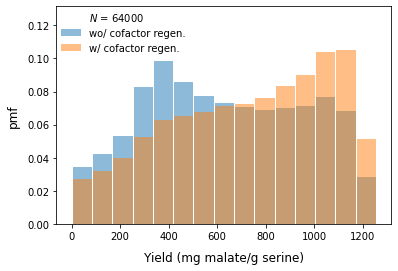

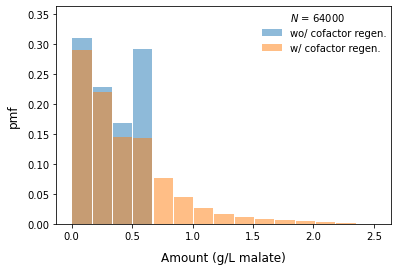

In [11]:
for i,t in enumerate(['Yield (mg malate/g serine)','Amount (g/L malate)']):
    plt.figure()
    num_bins = 15
    for m in allM:
        #plt.hist(m[:,i], bins = 20, alpha = 0.5, density = True)
        mmax = max([m[:,i].max() for m in allM])
        mmin = min([m[:,i].min() for m in allM])
        bins = np.linspace(mmin, mmax,num_bins+1)
        counts, _ = np.histogram(m[:,i], bins = bins)
        bins = bins[:-1] + (bins[1] - bins[0])/2
        probs = counts/float(counts.sum())
        plt.bar(bins, probs, width=(mmax-mmin)/num_bins*0.95, alpha = 0.5)

        print([m[:,i].mean(), m[:,i].std(), np.max(m[:,i])])
    plt.plot([0],[0], alpha = 0)
    plt.ylim([0,max(probs)*1.25])
    plt.legend(['$N$ = '+str(N),'wo/ cofactor regen.', 'w/ cofactor regen.'], frameon = False, borderpad = 0)
    plt.ylabel('pmf', fontsize = 12, labelpad = 7)
    plt.xlabel(t, fontsize = 12, labelpad = 10)

<AxesSubplot:>

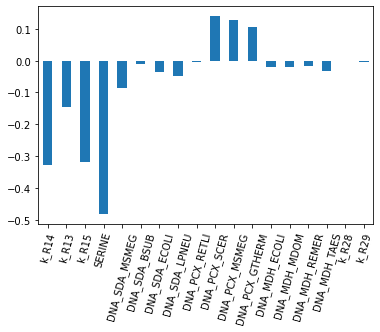

In [16]:
df = pd.DataFrame({**params,'yld':allM[0][:,0]})
(df.corr()['yld'][params.keys()]).plot(kind = 'bar', legend = False, rot = 75)

In [17]:
var_names = (['DNA_'+d for d in sdaV+pcxV+mdhV])
corr_list = []
for idx,v in enumerate(var_names):
    temp_df = df.loc[df[v] != 0]
    corr_list.append(temp_df.corr()['yld'][params.keys()][idx+4])


<BarContainer object of 12 artists>

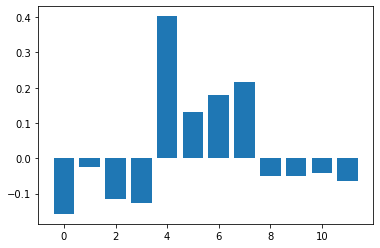

In [18]:
plt.bar(np.arange(12),corr_list)

<AxesSubplot:>

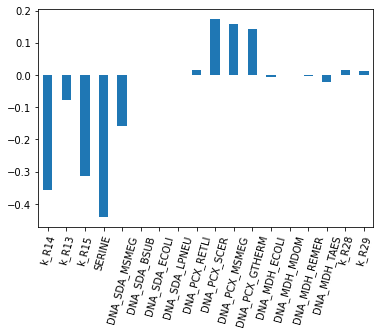

In [20]:
df = pd.DataFrame(parray, columns=params.keys())
df['yld'] = allM[0][:,0]

(df[df['DNA_'+sdaV[0]]>0].corr()['yld'][params.keys()]).plot(kind = 'bar', legend = False, rot = 75)

In [ ]:
import plotly.express as px
total = (MH.conditions[:,4:].sum(1))
stats = (MH.conditions[:,4:8].sum(1))/total
bus = (MH.conditions[:,8:12].sum(1))/total
design = (MH.conditions[:,12:].sum(1))/total
df = pd.DataFrame({'Sda':stats, 'PCX':bus, 'Mdh':design, "Yield": ylds})
fig = px.scatter_ternary(df, a="Sda", b="PCX", c="Mdh", opacity =0.05, color = "Yield", size = np.ones(N), size_max=25)
fig.show()